# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
twitter_archive = pd.read_csv('./twitter-archive-enhanced.csv')
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# # url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# response = requests.get(url)
# with open(os.path.join('image-predictions'), mode='wb') as file:
#     file.write(response.content)
# image_predictions = pd.read_csv('image-predictions', sep='\t')
# image_predictions.to_csv('image_predictions.tsv', index=False)

In [4]:
#loading tsv file of Image predictions dataframe
image_predictions = pd.read_csv('./image-predictions.tsv',sep='\t')
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
# import tweepy
# from tweepy import OAuthHandler
# import json
# from timeit import default_timer as timer

# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)

# df_1=pd.read_csv('./twitter-archive-enhanced.csv')
# tweet_ids = df_1.tweet_id.values
# len(tweet_ids)

# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

In [6]:
tweet_list=[]
with open('./tweet-json.txt',encoding ='utf-8',mode='r') as file:
    for rows in file:
        """
        "id":tweet ID,
        "retweet_count": retweet count,
        "favorite_count": favorite count.
        """
        data= json.loads(rows)
        json_data= {
            'tweet_id':data['id'],
            'retweet_count':data['retweet_count'],
            'favorite_count':data['favorite_count']}
        tweet_list.append(json_data)
#Convert to dataframe
tweet=pd.DataFrame(tweet_list, columns=['tweet_id','retweet_count','favorite_count'])
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [7]:
#enlarge the width of row
pd.set_option('max_colwidth',200)

In [8]:
twitter_archive.head(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [9]:
twitter_archive.tail(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2336,666273097616637952,NaN,NaN,2015-11-16 15:14:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Can take selfies 11/10 https://t.co/ws2AMaNwPW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666273097616637952/photo/1,11,10,None,None,None,None,None
2337,666268910803644416,NaN,NaN,2015-11-16 14:57:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Very concerned about fellow dog trapped in computer. 10/10 https://t.co/0yxApIikpk,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666268910803644416/photo/1,10,10,None,None,None,None,None
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None
2339,666102155909144576,NaN,NaN,2015-11-16 03:55:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666102155909144576/photo/1,11,10,None,None,None,None,None
2340,666099513787052032,NaN,NaN,2015-11-16 03:44:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Can stand on stump for what seems like a while. Built that birdhouse? Impressive. Made friends with a squirrel. 8/10 https://t.co/Ri4nMTLq5C,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666099513787052032/photo/1,8,10,None,None,None,None,None
2341,666094000022159362,NaN,NaN,2015-11-16 03:22:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This appears to be a Mongolian Presbyterian mix. Very tired. Tongue slip confirmed. 9/10 would lie down with https://t.co/mnioXo3IfP,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666094000022159362/photo/1,9,10,None,None,None,None,None
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a well-established sunblockerspaniel. Lost his other flip-flop. 6/10 not very waterproof https://t.co/3RU6x0vHB7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916733198337/photo/1,6,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Let's hope this flight isn't Malaysian (lol). What a dog! Almost completely camouflaged. 10/10 I trust this pilot https://t.co/Yk6GHE9tOY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100786774016/photo/1,10,10,None,None,None,None,None
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a northern speckled Rhododendron. Much sass. Gives 0 fucks. Good tongue. 9/10 would caress sensually https://t.co/ZoL8kq2XFx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193221509120/photo/1,9,10,None,None,None,None,None
2345,666063827256086533,NaN,NaN,2015-11-16 01:22:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666063827256086533/photo/1,10,10,the,None,None,None,None


> 1. The source column contains  html text content
> 2. There are a lot of missing columns related to status columns<retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp>.

In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [11]:
#check retweets volume
twitter_archive[twitter_archive.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,http...",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,http...",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https:/…,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724293877760/photo/1,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Extremely intelligent dog here. Has learned to walk like human. Even has his own dog. Very impressive 10/10 https://t.co/0Dv…,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269671505920/photo/1,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @twitter: @dog_rates Awesome Tweet! 12/10. Would Retweet. #LoveTwitter https://t.co/j6FQGhxYuN,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,"https://twitter.com/twitter/

In [12]:
#check pic missing data
twitter_archive[twitter_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [13]:
#check the dog name 
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
           ... 
Fletcher      1
Lizzie        1
Loomis        1
Dudley        1
Dot           1
Name: name, Length: 957, dtype: int64

In [14]:
# check the rating denominators
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [15]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
image_predictions[image_predictions.duplicated("jpg_url")]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [17]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [18]:
all_columns = pd.Series(list(twitter_archive) + list(image_predictions) + list(tweet))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

### Quality issues
> **table twitter_archive**

1.Some dogs have apparently unlikely names like the/a/an.

2.There are html tags in the source column.

3.There are various cases where the denominator is not 10 in the rating column.

4.Contains forwarded information.

5.expanded_urls has missing items.

6.There are too many missing items in in_reply_to_status_id, in_reply_to_user_id and need to be deleted.
> **table image_predictions**

7.The dtype of the tweet_id,timestamp column is incorrect.

8.There are duplicate image urls in the image_predictions table

### Tidiness issues
1.3 tables should be merged into one

2.the four columns of data about the stage should be merged into one column

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [19]:
# Make copies of original pieces of data
twitter_archive_clean=twitter_archive.copy()
image_predictions_clean=image_predictions.copy()
tweet_clean=tweet.copy()

### Issue #1:Some dogs have apparently unlikely names like the/a/an.

#### Define:Convert the names of a, the, an, None, in the name column to nan

#### Code

In [20]:
data=['a','the','an','None']
for name in data:
    twitter_archive_clean['name'] = twitter_archive_clean['name'].replace(name,np.nan)

#### Test

In [21]:
twitter_archive_clean['name'].value_counts()

Charlie     12
Lucy        11
Oliver      11
Cooper      11
Tucker      10
            ..
Fletcher     1
Lizzie       1
Loomis       1
Dudley       1
Dot          1
Name: name, Length: 953, dtype: int64

### Issue #2:There are html tags in the source column.

#### Define: delete the html tags

#### Code

In [22]:
twitter_archive_clean['source']

0       <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1       <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2       <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
3       <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
4       <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
                                               ...                                        
2351    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2352    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2353    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2354    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2355    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>

In [23]:
# #Regular expression to extract text
import re
twitter_archive_clean['source'] = twitter_archive_clean.source.str.extract(r'>(.*)<',re.S)

#### Test

In [24]:
twitter_archive_clean['source'].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Issue #3:There are various cases where the denominator is not 10 in the rating column.
#### Define: drop the different rows
#### Code

In [25]:
denominator_error=twitter_archive_clean[twitter_archive_clean.rating_denominator!=10]
twitter_archive_clean.drop(index=denominator_error.index,inplace=True)
twitter_archive_clean.reset_index(inplace=True)

#### test

In [26]:
twitter_archive_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

### Issue #4:Contains forwarded information.
#### Define: drop forwarded information.
#### Code

In [27]:
twitter_archive_clean=twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

#### test

In [28]:
twitter_archive_clean[twitter_archive_clean.retweeted_status_id.notnull()]

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [29]:
twitter_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1,inplace=True)

In [30]:
twitter_archive_clean.drop('index',axis=1,inplace=True)

### Issue #5:expanded_urls has missing items.
#### Define: drop missing items
#### Code

In [31]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.expanded_urls.notnull()]

#### test

In [32]:
twitter_archive_clean[twitter_archive_clean.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Issue #6:There are too many missing items in in_reply_to_status_id, in_reply_to_user_id
#### Define: drop the columns
#### Code

In [33]:
twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1,inplace=True)

#### test

In [34]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099 entries, 0 to 2332
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2099 non-null   int64 
 1   timestamp           2099 non-null   object
 2   source              2099 non-null   object
 3   text                2099 non-null   object
 4   expanded_urls       2099 non-null   object
 5   rating_numerator    2099 non-null   int64 
 6   rating_denominator  2099 non-null   int64 
 7   name                1422 non-null   object
 8   doggo               2099 non-null   object
 9   floofer             2099 non-null   object
 10  pupper              2099 non-null   object
 11  puppo               2099 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.2+ KB


### Issue #7:The dtype of the tweet_id,timestamp columns are incorrect.
#### Define: change type of tweet_id,timestamp
#### Code

In [35]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean.tweet_id.astype(str)
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean.timestamp)

#### test

In [36]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099 entries, 0 to 2332
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2099 non-null   object             
 1   timestamp           2099 non-null   datetime64[ns, UTC]
 2   source              2099 non-null   object             
 3   text                2099 non-null   object             
 4   expanded_urls       2099 non-null   object             
 5   rating_numerator    2099 non-null   int64              
 6   rating_denominator  2099 non-null   int64              
 7   name                1422 non-null   object             
 8   doggo               2099 non-null   object             
 9   floofer             2099 non-null   object             
 10  pupper              2099 non-null   object             
 11  puppo               2099 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

### Issue #8:There are duplicate image urls in the image_predictions table
#### Define: drop the duplicate items
#### Code

In [37]:
image_predictions_clean.drop_duplicates('jpg_url',inplace=True)

#### test

In [38]:
sum(image_predictions_clean.jpg_url.duplicated())

0

> ## Tidiness issues

### Issue #1: the four columns of data about the stage should be merged into one column.
#### define: Extract the dog's position from the text and store it in the stage, then delete the dog's position in 4 columns
#### Code

In [39]:
twitter_archive_clean['stage'] = twitter_archive_clean.text.str.lower().str.findall(r'(doggo|floof|pupper|puppo)').apply(lambda x : "|".join(set(x)))
twitter_archive_clean.drop(['doggo','puppo','pupper','floofer'], axis=1, inplace=True)

#### test

In [40]:
twitter_archive_clean['stage'].value_counts() 

                1704
pupper           240
doggo             77
floof             35
puppo             28
doggo|pupper      10
doggo|floof        2
puppo|doggo        2
floof|pupper       1
Name: stage, dtype: int64

### Issue #2:3 tables should be merged into one
#### Code

In [41]:
image_predictions_clean['tweet_id']=image_predictions_clean['tweet_id'].astype(str)

In [42]:
tweet_clean['tweet_id']=tweet_clean['tweet_id'].astype(str)

In [43]:
data_clean = twitter_archive_clean.merge(image_predictions_clean,how='inner',on='tweet_id')
data_clean = data_clean.merge(tweet_clean,how='left',on='tweet_id')

In [44]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976 entries, 0 to 1975
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1976 non-null   object             
 1   timestamp           1976 non-null   datetime64[ns, UTC]
 2   source              1976 non-null   object             
 3   text                1976 non-null   object             
 4   expanded_urls       1976 non-null   object             
 5   rating_numerator    1976 non-null   int64              
 6   rating_denominator  1976 non-null   int64              
 7   name                1376 non-null   object             
 8   stage               1976 non-null   object             
 9   jpg_url             1976 non-null   object             
 10  img_num             1976 non-null   int64              
 11  p1                  1976 non-null   object             
 12  p1_conf             1976 non-null 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [45]:
os.getcwd()

'C:\\Users\\u0008273\\Desktop\\python\\Jupyter\\Udacity_course\\4. Data Wrangling\\final project\\submission'

In [46]:
# data_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [47]:
twitter_archive_master = pd.read_csv('./twitter_archive_master.csv')
twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048


### Insights:
#### 1.Which resource is the most popular.

In [48]:
df=twitter_archive_master['source'].value_counts()
df

Twitter for iPhone    1937
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

In [49]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})

In [50]:
labels = np.full(len(df.values), "", dtype=object)
labels[0]='Twitter for iPhone'

### Visualization

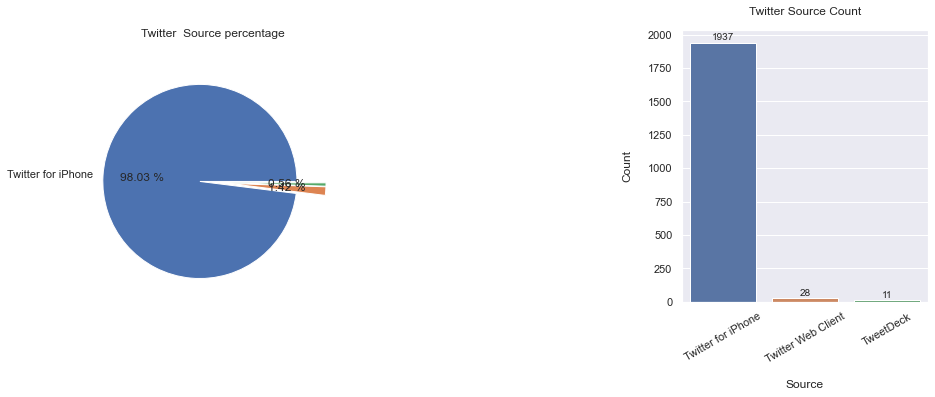

In [51]:
plt.subplot(133)
sns.barplot(x=df.index, y=df.values)
plt.title('Twitter Source Count', pad=15)
plt.ylabel('Count', labelpad=15)
plt.xlabel('Source', labelpad=15)
plt.xticks(rotation=30)
for x, y in enumerate(df.values):
    plt.text(x, y+20, "%s" %
             y, horizontalalignment='center', fontsize=10)
plt.subplot(131)
plt.pie(df.values,autopct='%3.2f %%',labels=labels, explode=(0.2,0.1,0.1))
plt.title('Twitter  Source percentage ')
plt.axis('square')
plt.show()

> 98% of the data comes from Twitter for iPhone (mobile client), with only a small portion from desktop apps and browsers. So most people prefer to use the Twitter mobile client to browse Twitter.

#### 2.Which breed of dog is the most popular

In [52]:
dog_type = []
for x in twitter_archive_master.index:
    if twitter_archive_master.loc[x,'p1_dog'] == True:
        dog_type.append(twitter_archive_master.loc[x,'p1'])
    elif twitter_archive_master.loc[x,'p2_dog'] == True:
        dog_type.append(twitter_archive_master.loc[x,'p2'])
    elif twitter_archive_master.loc[x,'p3_dog'] == True:
        dog_type.append(twitter_archive_master.loc[x,'p3'])

In [53]:
top_10=pd.Series(dog_type).value_counts()[:10]

### Visualization

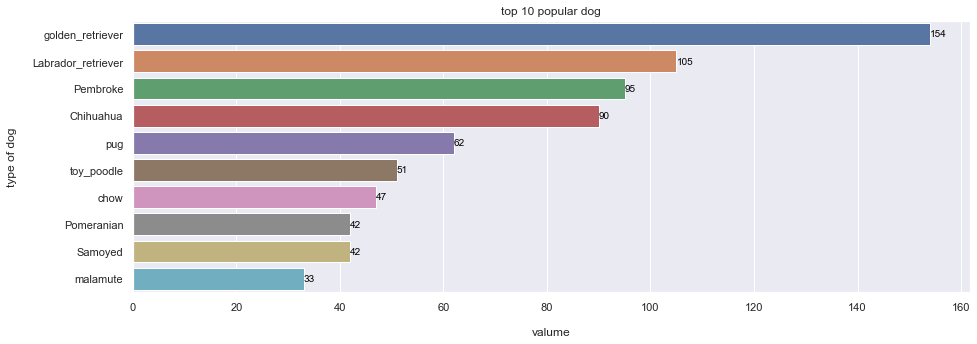

In [54]:

sns.barplot(y=top_10.index, x=top_10.values, orient='h')
for x, y in enumerate(top_10.values):
    plt.text(y, x, f'{y}', ha='left', va='center',
             fontsize=10, color='black')
plt.title('top 10 popular dog')
plt.ylabel('type of dog', labelpad=15)
plt.xlabel('valume', labelpad=15)
plt.show()

> It can be seen from the table that everyone likes the  dog **Golden Retriever**.

3.Is there any relationship between favorite_count and retweet_count?

### Visualization

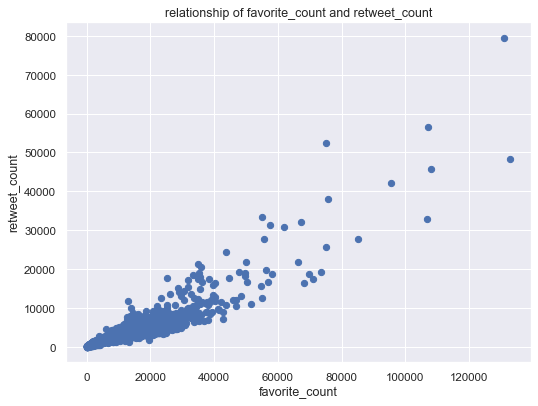

In [55]:
plt.figure(figsize=(8,6),dpi=75) 
plt.scatter(twitter_archive_master['favorite_count'],twitter_archive_master['retweet_count'])
plt.xlabel('favorite_count')
plt.ylabel('retweet_count')
plt.title('relationship of favorite_count and retweet_count')
plt.show()

> It can be found from the figure that there is a strong positive correlation between favorite_count and retweet_count. The higher the number of **favorite_count**, the higher the **retweet_count**.

#### 4.Which stage of dog is the most popular

#### Visualization

Text(0, 0.5, 'Frequency')

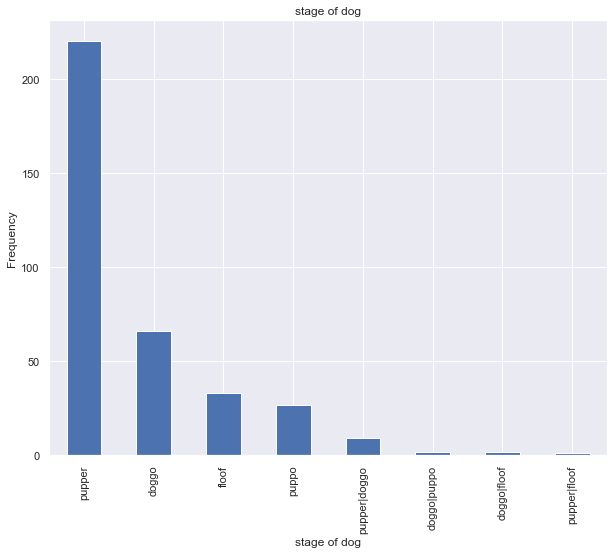

In [56]:
bar = twitter_archive_master['stage'].value_counts().plot(kind='bar',
                                                          figsize=(10, 8),
                                                          title="stage of dog")
bar.set_xlabel("stage of dog")
bar.set_ylabel("Frequency")

> As we can see the barplot, the most popular stage of dog is **pupper**.